# Recovering rotation periods in simulated LSST data

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from gatspy.periodic import LombScargle
import sys
%matplotlib inline
from toy_simulator import simulate_LSST
from trilegal_models import random_stars
import barnes as bn

Randomly select targets from a TRILEGAL output.

In [65]:
fname = "output574523944248.dat"
N = 100
logAges, bvs = random_stars(fname, N)
age = 10**logAges * 1e-9
ps = bn.period(age, bvs)

Make histograms of the ages and periods

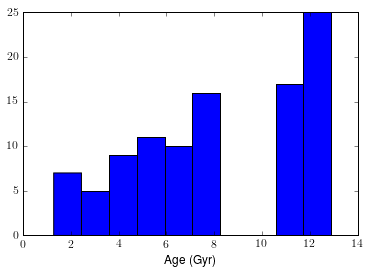

In [66]:
plt.hist(age)
plt.xlabel("Age (Gyr)")

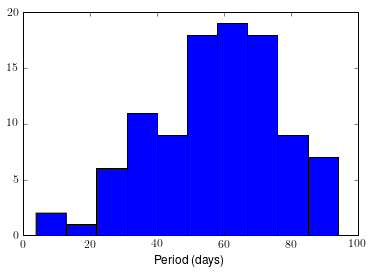

In [67]:
plt.hist(ps)
plt.xlabel("Period (days)")

In [68]:
## Arrays of random (log-normal) periods and (uniform) amplitudes.
#min_period, max_period = 1, 100  # days
#ps = np.exp(np.random.uniform(np.log(min_period), np.log(max_period), N))  # periods
#amps = np.random.uniform(10, 300, N)  # ppm

Simulate light curves

In [69]:
%%capture
amps = np.random.uniform(10, 300, N)  # ppm
path = "simulations"  # where to save the lcs
[simulate_LSST(i, ps[i], amps[i], path) for i in range(N)]  # simulations

# save the true values
ids = np.arange(N)
data = np.vstack((ids, ps, amps))
np.savetxt("{0}/truth.txt".format(path), data.T)

Load and plot an example light curve

<Container object of 3 artists>

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


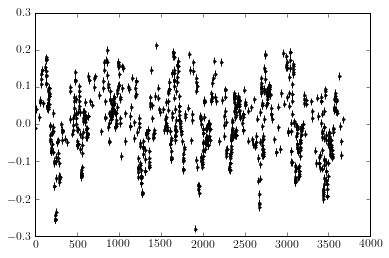

In [70]:
id = 0
sid = str(int(id)).zfill(4)
path = "results"  # where to save results
x, y, yerr = np.genfromtxt("simulations/{0}.txt".format(sid)).T  # load a fake light curve
plt.errorbar(x, y, yerr=yerr, fmt="k.", capsize=0)

Compute a periodogram

42.7107107107 49.4372223736


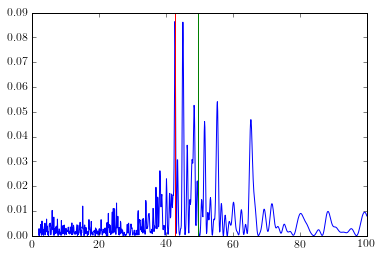

In [71]:
ps = np.linspace(2, 100, 1000)  # the period array (in days)
model = LombScargle().fit(x, y, yerr)
pgram = model.periodogram(ps)

# find peaks
peaks = np.array([i for i in range(1, len(ps)-1) if pgram[i-1] < pgram[i] and pgram[i+1] < pgram[i]])
if len(peaks):
    period = ps[pgram==max(pgram[peaks])][0]
else: period = 0

plt.plot(ps, pgram)  # plot the pgram
plt.axvline(period, color="r")  # plot the position of the highest peak

# load and plot the truth
ids, true_ps, true_as = np.genfromtxt("simulations/truth.txt").T
plt.axvline(true_ps[id], color="g")  # plot the position of the highest peak

print(period, true_ps[id])

Now compute LS pgrams for a set of LSST light curves and save the highest peak .

In [72]:
ids = np.arange(N)
periods = np.zeros_like(ids)
for i, id in enumerate(ids):
    sid = str(int(id)).zfill(4)
    x, y, yerr = np.genfromtxt("simulations/{0}.txt".format(sid)).T  # load a fake light curve

    model = LombScargle().fit(x, y, yerr)  # compute pgram
    pgram = model.periodogram(ps)

    # find peaks
    peaks = np.array([i for i in range(1, len(ps)-1) if pgram[i-1] < pgram[i] and pgram[i+1] < pgram[i]])
    if len(peaks):
        period = ps[pgram==max(pgram[peaks])][0]
    else: period = 0

    periods[i] = period

Plot the recovered periods vs the true periods.

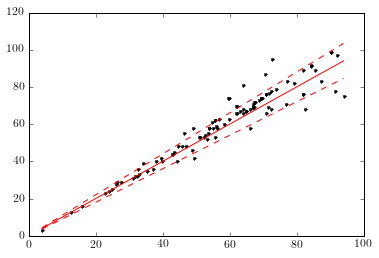

In [78]:
plt.plot(true_ps, periods, "k.")
xs = np.linspace(min(true_ps), max(true_ps), 100)
plt.plot(xs, xs, "r")

tau = .1  # the recovery must be within a factor of *threshold* of the truth
plt.plot(xs, xs-tau*xs, "r--")
plt.plot(xs, xs+tau*xs, "r--")

Decide whether the recovery was successful or not

(array([  2.,   6.,   7.,   8.,  10.,  15.,  18.,  12.,   7.,   8.]),
 array([ 12.65049839,  20.58872452,  28.52695064,  36.46517676,
         44.40340289,  52.34162901,  60.27985514,  68.21808126,
         76.15630739,  84.09453351,  92.03275963]),
 <a list of 10 Patch objects>)

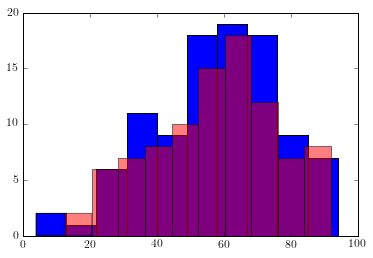

In [75]:
m = (true_ps - tau*true_ps < periods) * (periods < true_ps + tau*true_ps)

plt.hist(true_ps, color="b")
plt.hist(true_ps[m], color="r", alpha=.5)